# Double-Stack BERT for Operational Phase
After pre-training the previously needed components, we can make a class for compiling the whole Double-Stack BERT.

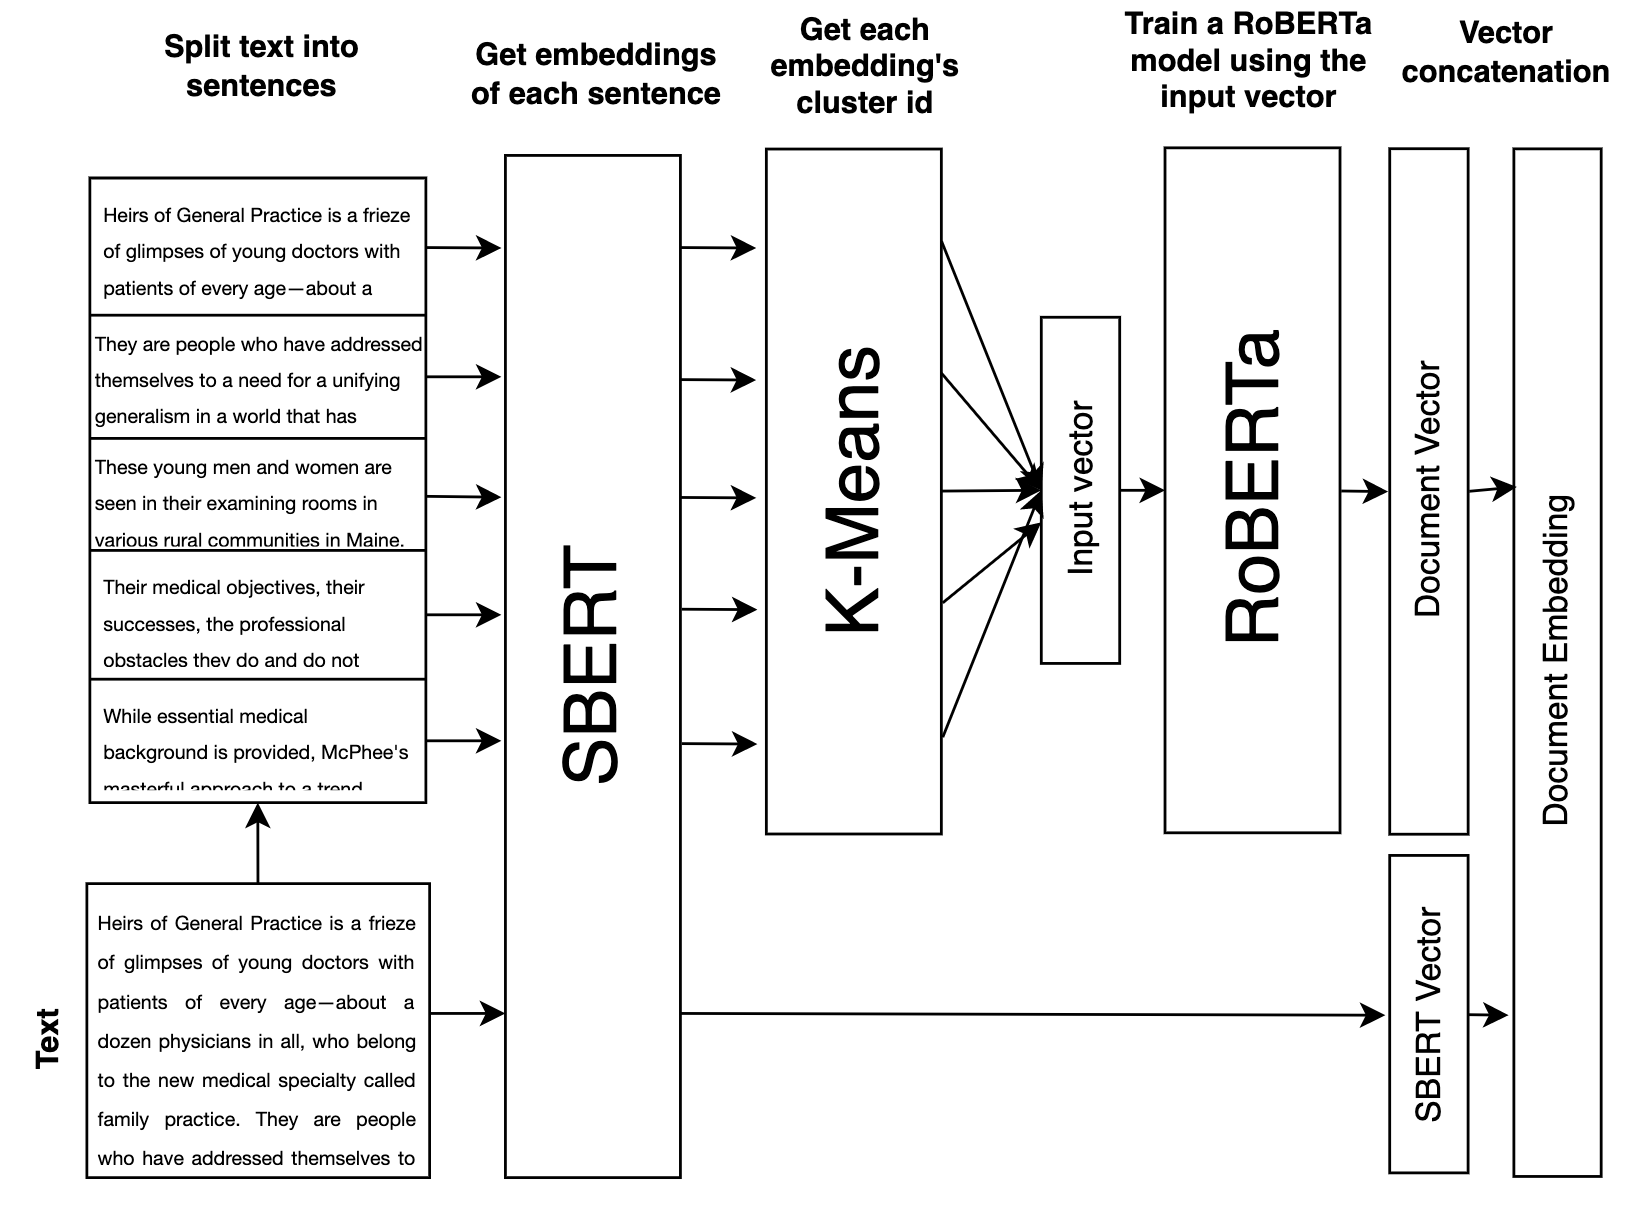

## Model Class

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tqdm.auto import tqdm
import re
from scipy.cluster.vq import *
import torch
import torch.nn as nn
import torch.optim as optim
import math
import json
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM, RobertaModel
from transformers import AdamW

In [6]:
class DoubleStackBERT:
    def __init__(self, tokenizer_source): 
        self.model = RobertaModel.from_pretrained('doublestackbert')
        self.codebook = np.load(tokenizer_source+'/codebook.npy')
        with open(tokenizer_source+'/vocabs.json') as json_file:
            self.__vocabs = json.load(json_file)
        self.sentenceTransformer = SentenceTransformer('all-mpnet-base-v2')
        self.bos_token = self.cls_token = '<s>'
        self.eos_token = self.sep_token = '</s>'
        self.unk_token = '<unk>'
        self.pad_token = '<pad>'
        self.mask_token = '<mask>'
        self.mask_token_id = self.__vocabs['<mask>']

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # and move our model over to the selected device
        self.model.to(self.device)
        
    def getVocabSize(self):
        return len(self.__vocabs)
  
    # splitting text into sentences
    # receives a string as parameter
    # returns an array of string(s)
    # library dependencies: re
    def __splitTextToSentences(self,text):
        try:
            arrayOfSentences = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)
        except:
            arrayOfSentences = [""]
        return arrayOfSentences

    # Turns an array of raw text into each of it sentences embedding
    # receives a pretrained Sentence-BERT model and the intended dataset
    # returns 2D array. Each index contains a list of embedded strings
    # library dependencies: sentence_transformers
    # local function dependencies: splitTextToSentences  
    def __getSentencesEmbedding(self, dataset):
        # splitting eaxh text of the dataset into a list of sentences using previously made function
        array = []
        if type(dataset) == str: # if single query
            array.append(dataset)
        else: # if multiple queries
            array = dataset

        sentences_dataset = [self.__splitTextToSentences(text) for text in array]
        dataset_embeddings = []
        for i in range(len(sentences_dataset)):
            embeddings = self.sentenceTransformer.encode(sentences_dataset[i])
            dataset_embeddings.append(embeddings)

        return dataset_embeddings
  
    # Parameter: max_length, padding='max_length', truncation)
    def tokenize(self, list_of_docs, max_length= -1, padding = True, truncation = True): 
        docs_tokens = [] 
        doc_embeddings = self.__getSentencesEmbedding(list_of_docs)
        for doc in doc_embeddings:
            sentences_cluster_ids = vq(doc,self.codebook)
            sentences_token_ids = []
            attention_mask = []
            for cluster_id in sentences_cluster_ids[0]: 
                sentences_token_ids.append(self.__vocabs[str(cluster_id)])

            if truncation and max_length != -1 :
                if len(sentences_token_ids) + 2 > max_length:
                    sentences_token_ids = sentences_token_ids[:(max_length-2)]
                    padding = False

            input_ids = [self.__vocabs['<s>']] + sentences_token_ids + [self.__vocabs['</s>']]
            attention_mask.extend([1] * len(input_ids))

            if padding:
                padding_len = max_length - len(input_ids)
                input_ids.extend([self.__vocabs['<pad>']] * padding_len)
                attention_mask.extend([0] * padding_len)

            docs_tokens.append({'input_ids':input_ids, 'attention_mask':attention_mask})

        return docs_tokens

    def getTensors(self,dataset,max_length= -1, padding = True, truncation = True):
        tensors = []
        if type(dataset) is str:
            dataset = [dataset]
        for d in dataset:
            t = torch.tensor([self.tokenize(d,max_length,padding,truncation)[0]['input_ids']])
            output = self.model(t).pooler_output.cpu().detach().numpy()
            tensors.append(output.reshape((output.shape[1])))
        return tensors

    def getEmbeddings(self,dataset, max_length= -1, padding = True, truncation = True):
        if type(dataset) == str:
            dataset = [dataset]
        embeddings = self.sentenceTransformer.encode(dataset)
        tensors = self.getTensors(dataset,max_length,padding,truncation)
        return np.concatenate((embeddings, tensors), axis=1)

In [7]:
model = DoubleStackBERT('doublestackbert_tokenizer')

Some weights of the model checkpoint at doublestackbert were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at doublestackbert and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Example Usage

In [8]:
example_text = ["By midnight the party will be completely out of control. By morning, the Riva mansion will have gone up in flames. But before that first spark in the early hours before dawn, the alcohol will flow, the music will play, and the loves and secrets that shaped this family’s generations will all come bubbling to the surface."]

example_output = model.getEmbeddings(example_text, max_length=32, padding=True, truncation=True)

print("Example Text:")
print(example_text[0])
print()
print("Example output:")
print(example_output)

Example Text:
By midnight the party will be completely out of control. By morning, the Riva mansion will have gone up in flames. But before that first spark in the early hours before dawn, the alcohol will flow, the music will play, and the loves and secrets that shaped this family’s generations will all come bubbling to the surface.

Example output:
[[ 0.00336374  0.00133972 -0.0274082  ...  0.35746098 -0.71042794
   0.30013755]]


In [9]:
print("Output size:", example_output.shape[1])

Output size: 1536
